In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
## Load dataset
K = 3
N_c, N_s, N_t = 70, 72, 72
N = N_c+N_s+N_t
data_path = data_dir + "ncmm/shapes_c=%d_s=%d_t=%d" % (N_c, N_s, N_t)

OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
## Hyper Parameters
NUM_DATASETS = OB.shape[0]

## Train Parameters
NUM_EPOCHS = 500

D = 2
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))

CUDA = torch.cuda.is_available()
DEVICE = 1
RECON_SIGMA = torch.ones(1) * 0.2
# lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
PATH = 'dec-%dpts-%dsamples' % (N_c+N_s+N_t, SAMPLE_SIZE)
## MOdel Parameters
NUM_HIDDEN_LOCAL = 64
NUM_HIDDEN = 32
NUM_NSS = 8
LEARNING_RATE = 1e-3
Train_Params = (NUM_EPOCHS, K, D, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)

In [7]:
from decoder_shapes import *
from local_oneshot_state_shapes import *
from local_enc_angle import *
dec_x = Dec_x(D, NUM_HIDDEN, RECON_SIGMA, CUDA, DEVICE)
# f_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
# f_state = Oneshot_state(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)

if CUDA:
    with torch.cuda.device(DEVICE):
        dec_x.cuda()
#         f_angle.cuda()
#         f_state.cuda()
        
optimizer =  torch.optim.Adam(list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [8]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices]
        angle = ANGLE[batch_indices]
        ob_embedding = torch.cat((ob, angle, state), -1)
        ob_embedding = shuffler(ob_embedding).repeat(SAMPLE_SIZE, 1, 1, 1)
        mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob_embedding =ob_embedding.cuda()
                mu = mu.cuda()
        ob = ob_embedding[:, :, :, :2]
        angle = ob_embedding[:, :, :, 2].unsqueeze(-1)
        state = ob_embedding[:,:,:, 3:]
        p = dec_x(ob, state, angle, mu)
        ll = p['likelihood'].log_prob.sum(-1) ## S * B * N
        loss_theta = -ll.sum(-1).mean()
        ## gradient step
        loss_theta.backward()
        optimizer.step()  
        LOSS += loss_theta.detach()
    if epoch % 1 == 0:
        time_end = time.time()
        print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, loss=2216.5596 (3s)
epoch=1, loss=-76.0917 (3s)
epoch=2, loss=-164.4900 (3s)
epoch=3, loss=-199.6675 (3s)
epoch=4, loss=-210.9666 (3s)
epoch=5, loss=-216.6040 (3s)
epoch=6, loss=-219.8336 (3s)
epoch=7, loss=-221.6509 (3s)
epoch=8, loss=-222.8992 (3s)
epoch=9, loss=-223.9493 (3s)
epoch=10, loss=-224.9057 (3s)
epoch=11, loss=-225.7846 (3s)
epoch=12, loss=-226.6005 (3s)
epoch=13, loss=-227.2903 (3s)
epoch=14, loss=-227.9053 (3s)
epoch=15, loss=-228.4583 (3s)
epoch=16, loss=-228.9980 (3s)
epoch=17, loss=-229.5078 (3s)
epoch=18, loss=-229.9724 (3s)
epoch=19, loss=-230.3936 (3s)
epoch=20, loss=-230.7685 (3s)
epoch=21, loss=-231.1023 (3s)
epoch=22, loss=-231.3992 (3s)
epoch=23, loss=-231.6859 (3s)
epoch=24, loss=-231.9158 (3s)
epoch=25, loss=-232.1615 (3s)
epoch=26, loss=-232.3665 (3s)
epoch=27, loss=-232.5657 (3s)
epoch=28, loss=-232.7465 (3s)
epoch=29, loss=-232.9353 (3s)
epoch=30, loss=-233.0961 (3s)
epoch=31, loss=-233.2562 (3s)
epoch=32, loss=-233.4034 (3s)
epoch=33, loss=-233.5

KeyboardInterrupt: 

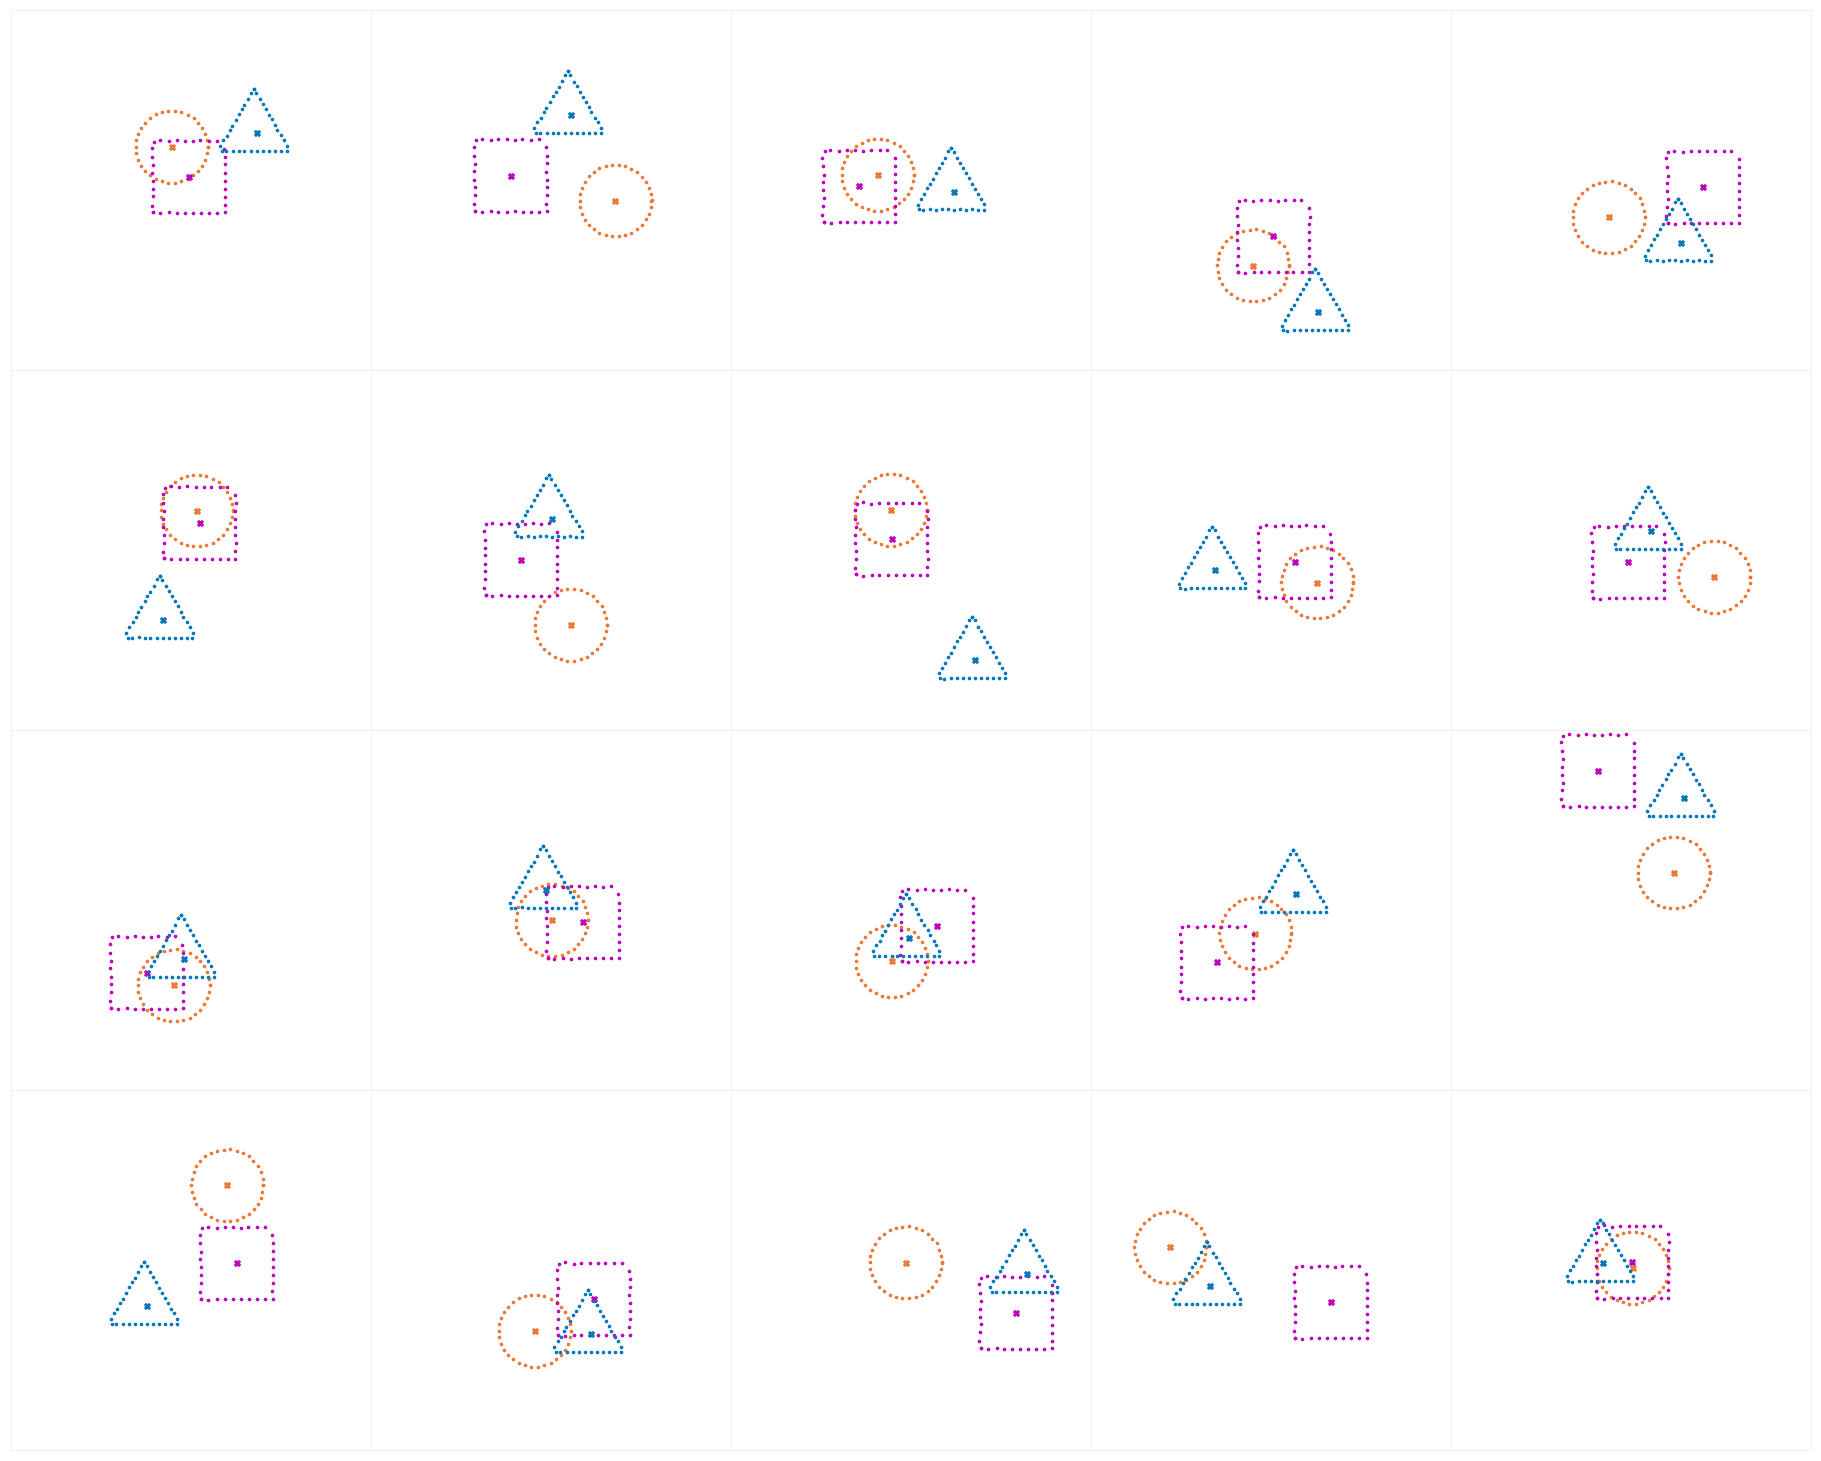

In [15]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from plots import plot_final_samples
    
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
mu = MU[batch_indices]
angle = ANGLE[batch_indices]
ob_embedding = torch.cat((ob, angle, state), -1)
ob_embedding = shuffler(ob_embedding).repeat(SAMPLE_SIZE, 1, 1, 1)
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        ob_embedding =ob_embedding.cuda()
        mu = mu.cuda()
ob = ob_embedding[:, :, :, :2]
angle = ob_embedding[:, :, :, 2].unsqueeze(-1)
state = ob_embedding[:,:,:, 3:]
p = dec_x(ob, state, angle, mu)

# E_state =  q_state['states'].dist.probs[0].cpu().data.numpy()
recon_mu = p['likelihood'].dist.loc[0].cpu().data.numpy()
plot_final_samples(recon_mu, mu[0].cpu().data.numpy(), state[0].cpu().data.numpy(), K, PATH)

In [ ]:
plot_final_samples(ob[0].cpu().data.numpy(), mu[0].cpu().data.numpy(), E_state, K, PATH)